In [33]:
import word2vec as w2v
import pandas as pd
# import cupy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import re
import os
import random
import warnings
import datetime
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [34]:
def FilterDataset(dataset, size) :
	filtered = dataset.copy().head(size)
	for text, idx in zip(filtered.content.values, filtered.index.values) :
		tmp = np.array([word for word in re.sub('\W', ' ', re.sub("[’']", "", re.sub("http[\S]+", "URL", text, flags=re.U), flags=re.U), flags=re.U).lower().split()])
		if len(tmp) <= 1 :
			filtered.loc[idx]
			filtered = filtered.drop(idx)
	return filtered

In [35]:
# trumpTweets_DF = pd.read_csv("realdonaldtrump.csv", sep=",")

In [36]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(trumpTweets_DF.retweets, 'o', label="retweets")
# plt.plot(trumpTweets_DF.favorites, 'o', label="likes")
# plt.legend()

In [37]:
def LoadDataset(version, size, vec_size):
	trumpTweets_DF = pd.read_csv("realerdonaldertrumper.csv", sep=",")

	result_data = w2v.Word2Vec()
	result_data.loadFromFile("./models_" + str(version) + "/calculated_model_" + str(size) + "_" + str(vec_size) + ".txt")
	result = result_data.words_df
	# print(1- cosine(result.loc[result["word"].isin(["donald"])]["vector"][0], result.loc[result["word"].isin(["trump"])]["vector"][0]))
	# print(result.shape)
	filtered_df = FilterDataset(trumpTweets_DF, size)

	list_of_tweets = w2v.stripPunctuation(filtered_df.content[:size])

	filtered_df["content_vectors"] = [np.vstack(result.loc[result.word.isin(tweet)].vector.values) for tweet in list_of_tweets]
	longest_tweet = 0
	for tweet in filtered_df["content_vectors"] :
		if tweet.shape[0] > longest_tweet :
			longest_tweet = tweet.shape[0]
	for i, tweet in zip(filtered_df.index, filtered_df["content_vectors"]) :
		filtered_df["content_vectors"][i] = np.pad(tweet, [(0, longest_tweet - tweet.shape[0]), (0,0)])
	input_mtx = np.stack(filtered_df["content_vectors"])
	input_y = filtered_df.retweets.values
	# input_y = np.c_[input_y, filtered_df.favorites.values]
	# input_y = input_y.mean(axis=1)
	print(input_y.shape)
	
	input_y = np.log(input_y)
	flat_X = input_mtx.mean(axis=1)
	flat_X = np.c_[flat_X, np.array([tweet.shape[0] / longest_tweet for tweet in list_of_tweets])]
	timestamp = []
	datetime_frame = [np.inf, -np.inf]
	for date in filtered_df.date.values :
		timestamp.append(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()))
		if timestamp[-1] < datetime_frame[0]:
			datetime_frame[0] = timestamp[-1]
		elif timestamp[-1] > datetime_frame[1]:
			datetime_frame[1] = timestamp[-1]

	flat_X = np.c_[flat_X, np.array([(date - datetime_frame[0]) / datetime_frame[1] for date in timestamp])]
	flat_X = np.c_[flat_X, filtered_df.haslink.values]
	
	return flat_X, input_y

In [38]:
def train_test_split(input_mtx, input_y, test_size):
	random.seed(1234123)
	test_split = random.choices([i for i in range(input_mtx.shape[0])], k= int(np.round(test_size * input_mtx.shape[0])))
	train_split = [i for i in range(input_mtx.shape[0]) if i not in test_split]
	return train_split, test_split

In [39]:
def score(y_true, y_pred) :
	sum_squares_residuals = np.array((((y_true - y_pred) * 1e+4) ** 2), dtype=np.int64).sum()
	print(sum_squares_residuals)
	sum_squares = np.array((((y_true - np.array(y_true * 1e+6, dtype = np.int64).sum() * 1e-6 / y_true.shape[0]) * 1e+4) ** 2), dtype=np.int64).sum()
	print(sum_squares)
	R2 = 1 - sum_squares_residuals / sum_squares
	return np.round(R2 * 100, 2)

In [40]:
# def score2(y_true, y_pred) :
# 	sum_squares_residuals = (((y_true - y_pred)) ** 2).sum()
# 	print(sum_squares_residuals)
# 	sum_squares = (((y_true - y_true.mean())) ** 2).sum()
# 	print(sum_squares)
# 	R2 = 1 - sum_squares_residuals / sum_squares
# 	return np.round(R2 * 100, 2)

In [41]:
def calculateModel(input_mtx, input_y, train_split, test_split, batch_proc, max_layer, layer_step, verbose) :
	tf.keras.utils.set_random_seed(0)

	print(input_mtx.shape[1:])
	retweets_model = keras.Sequential()
	retweets_model.add(keras.Input(shape=input_mtx.shape[1:]))
	# retweets_model.add(keras.layers.Flatten())
	retweets_model.add(keras.layers.Dense(max_layer, activation="linear"))
	for neuron_size in range(max_layer -1, 1, -layer_step):
		retweets_model.add(keras.layers.Dense(neuron_size, activation="linear"))
	retweets_model.add(keras.layers.Dense(1, activation="linear"))
	retweets_model.compile(loss="msle", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['mae', 'mse', 'msle', 'poisson'])

	with tf.device('/GPU:0') :
		history = retweets_model.fit(input_mtx[train_split], input_y[train_split], validation_split=0.2, verbose=verbose, epochs=100, batch_size=int(batch_proc * input_mtx.shape[0]), shuffle=True)
	R2_train = score(input_y[train_split].reshape(-1,1), retweets_model.predict(input_mtx[train_split]))
	R2_test = score(input_y[test_split].reshape(-1,1), retweets_model.predict(input_mtx[test_split]))
	return R2_train, R2_test, history, retweets_model

In [42]:
def plotR2(r2_list) :
	plt.figure(figsize=(15,10))
	plt.plot([scores[0] for scores in r2_list], label="train")
	plt.plot([scores[1] for scores in r2_list], label="test")
	for i, scores in enumerate(r2_list) :
		plt.annotate(scores[0], [i, scores[0]])
		plt.annotate(scores[1], [i, scores[1]])
	plt.legend()
	plt.show()

In [43]:
# X, Y = LoadDataset(1000, 500)
# train_split, test_split = train_test_split(X,Y, 0.2)

In [44]:
# def parallelCalcModel(layers_range) :
	

In [45]:
r2_list = []
for layer in range(70, 80, 1):
	X, Y = LoadDataset("v2", 1000, 500)
	train_split, test_split = train_test_split(X,Y, 0.2)
	result = calculateModel(X, Y, train_split, test_split, 0.2, layer, 1, verbose=0)
	history = result[2]
	r2_list.append(result[:2])

FileNotFoundError: [Errno 2] No such file or directory: './models/calculated_model_1000_500.txt'

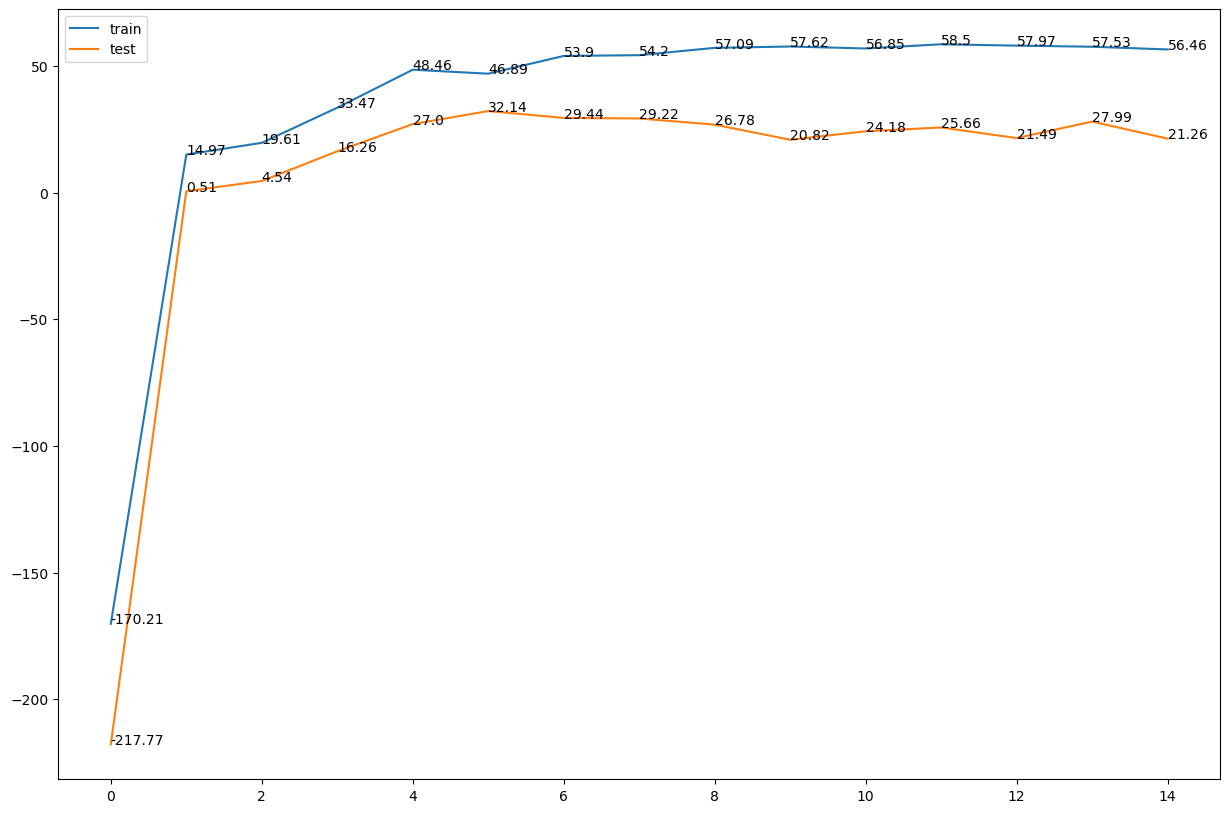

In [ ]:
plotR2(r2_list)


In [ ]:

# for vec_size in [100,200,400,500] :
# 	X, Y = LoadDataset(1000, vec_size)
# 	train_split, test_split = train_test_split(X,Y, 0.2)
# 	r2_list = []
# 	for batch_proc in np.arange(0.1,1, 0.1) :
# 		print("calculating for",batch_proc)
# 		r2_list.append(calculateModel(X,Y,train_split,test_split,batch_proc))
# 		plotR2(r2_list)

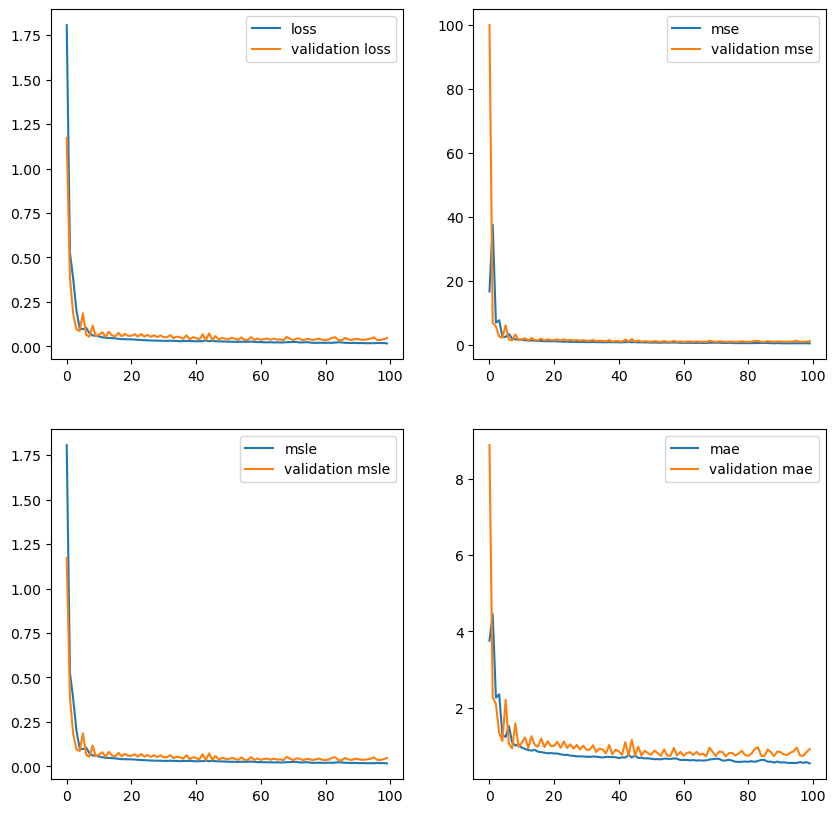

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history.history['mse'], label = 'mse')
plt.plot(history.history['val_mse'], label = 'validation mse')
plt.legend()
plt.subplot(2,2,3)
plt.plot(history.history['msle'], label = 'msle')
plt.plot(history.history['val_msle'], label = 'validation msle')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'validation mae')
plt.legend()
plt.show()


7/7 [==============================] - 0s 33ms/step


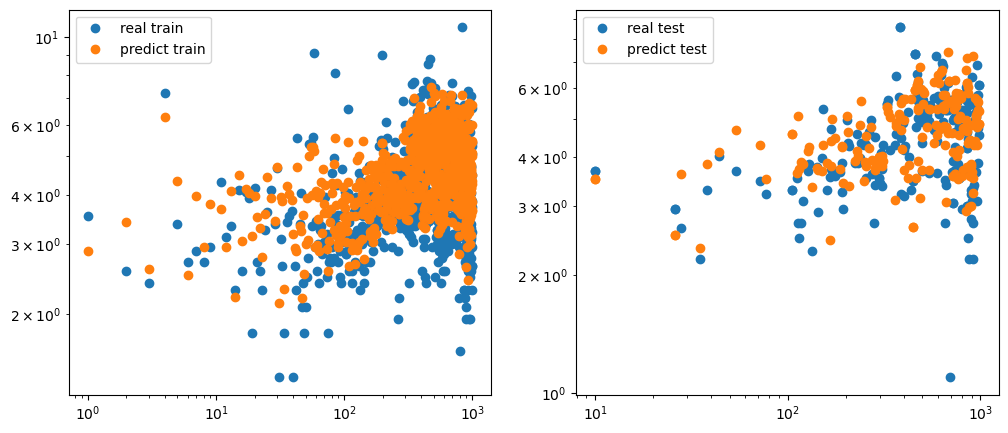

In [ ]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.xscale('log')
plt.yscale('log')
# plt.plot(wordy_train.index, wordy_train.values, 'o', label="real train")
# plt.plot(wordy_train.index, retweets_model.predict(wordX_train), 'o', label="predict train")
plt.plot(train_split, Y[train_split], 'o', label="real train")
plt.plot(train_split, result[3].predict(X[train_split]), 'o', label="predict train")

plt.legend()
plt.subplot(1,2,2)
plt.xscale('log')
plt.yscale('log')
plt.plot(test_split, Y[test_split], 'o', label="real test")
plt.plot(test_split, result[3].predict(X[test_split]), 'o', label="predict test")
plt.legend()


In [ ]:
# R2_train = score(input_y[train_split].reshape(-1,1), retweets_model.predict(input_mtx[train_split]))
# print("R^2 Score train: %3.2f" % R2_train + "%")
# R2_test = score(input_y[test_split].reshape(-1,1), retweets_model.predict(input_mtx[test_split]))
# print("R^2 Score test: %3.2f" % R2_test + "%")
# msle_score = keras.metrics.MeanSquaredLogarithmicError()
# msle_score.update_state(input_y[train_split].reshape(-1,1),retweets_model.predict(input_mtx[train_split]))
# print("MSLE Score train:", msle_score.result())
# msle_score = keras.metrics.MeanSquaredLogarithmicError()
# msle_score.update_state(input_y[test_split].reshape(-1,1),retweets_model.predict(input_mtx[test_split]))
# print("MSLE Score test:", msle_score.result())

In [ ]:
# pred_test = retweets_model.predict(input_mtx[test_split])
# for i in range(input_y[test_split].shape[0]) :
#   print(np.round(np.exp(input_y[test_split][i])), np.round(np.exp(pred_test[i])))

In [ ]:
# pred_test = retweets_model.predict(wordX_test)
# for i in range(wordy_test.shape[0]) :
#   print(np.round(wordy_test.values[i]), np.round(pred_test[i]))